# Выбор локации для скважины

**Описание проекта:**

Цель: найти регион, в котором бурить новую скважину добывающей компании «ГлавРосГосНефть».

Имеем пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных:**

 - id — уникальный идентификатор скважины;
 - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
 - product — объём запасов в скважине (тыс. баррелей).


## Загрузка и подготовка данных

In [1]:
import pandas as pd #импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
region_1 = pd.read_csv('/datasets/geo_data_0.csv')
region_2 = pd.read_csv('/datasets/geo_data_1.csv')
region_3 = pd.read_csv('/datasets/geo_data_2.csv') #прочитаем файлы

In [3]:
regions = (region_1, region_2, region_3)

Посмотрим основные статистические характеристики данных каждого региона по числовому признаку

In [4]:
def discover(data):
    display(data.describe()) #общие данные
    display(f'Количество пропусков:{data.isna().sum()}')
    display(f'Количество дубликатов:{data.duplicated().sum()}')

In [5]:
print('Первый регион')
discover(region_1)

Первый регион


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'Количество пропусков:id         0\nf0         0\nf1         0\nf2         0\nproduct    0\ndtype: int64'

'Количество дубликатов:0'

In [6]:
print('Второй регион')
discover(region_2)

Второй регион


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'Количество пропусков:id         0\nf0         0\nf1         0\nf2         0\nproduct    0\ndtype: int64'

'Количество дубликатов:0'

In [7]:
print('Третий регион')
discover(region_3)

Третий регион


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


'Количество пропусков:id         0\nf0         0\nf1         0\nf2         0\nproduct    0\ndtype: int64'

'Количество дубликатов:0'

In [8]:
for data in regions:
        unique = data['id'].unique()
        print(unique) #проверим на уникальность первый столбец

['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']
['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']
['fwXo0' 'WJtFt' 'ovLUW' ... 'tKPY3' 'nmxp2' 'V9kWn']


In [9]:
for data in regions:
    data.drop('id', axis=1, inplace=True) #удалим эту колонку

Посмотрим выбросы по признакам в датасетах

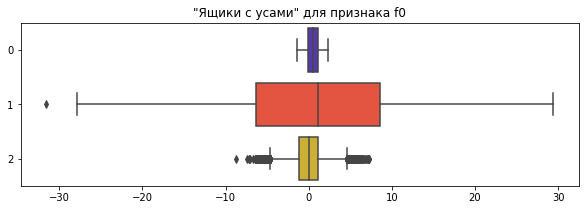

In [10]:
plt.figure(figsize=(10,3))
sns.boxplot(data=[region_1.f0, region_2.f0, region_3.f0], orient='h', palette='CMRmap')
plt.title('"Ящики с усами" для признака f0')
plt.show()

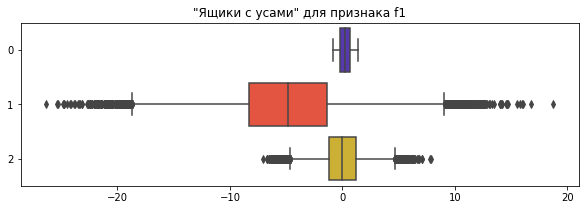

In [11]:
plt.figure(figsize=(10,3))
sns.boxplot(data=[region_1.f1, region_2.f1, region_3.f1], orient='h', palette='CMRmap')
plt.title('"Ящики с усами" для признака f1')
plt.show()

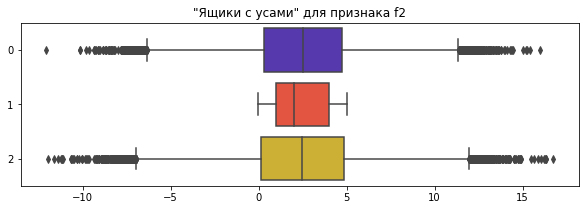

In [12]:
plt.figure(figsize=(10,3))
sns.boxplot(data=[region_1.f2, region_2.f2, region_3.f2], orient='h', palette='CMRmap')
plt.title('"Ящики с усами" для признака f2')
plt.show()

Распределение признаков в первом регионе


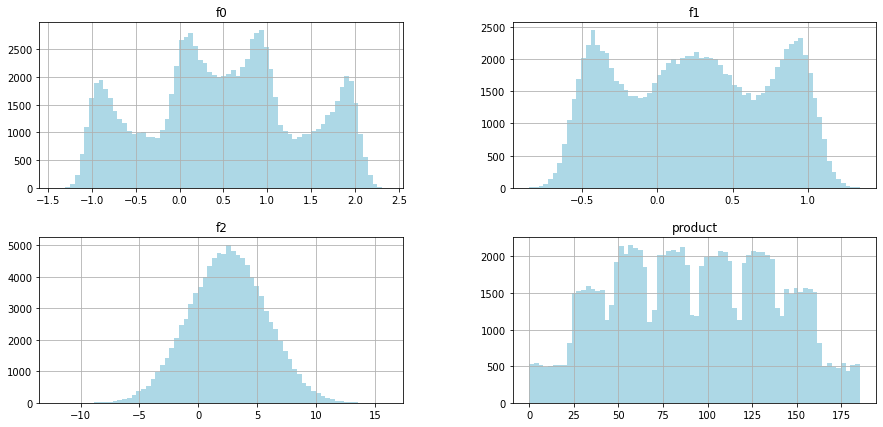

In [13]:
region_1.hist(figsize=(15, 7), bins=70, color='lightblue')
print('Распределение признаков в первом регионе')

Распределение признаков во втором регионе


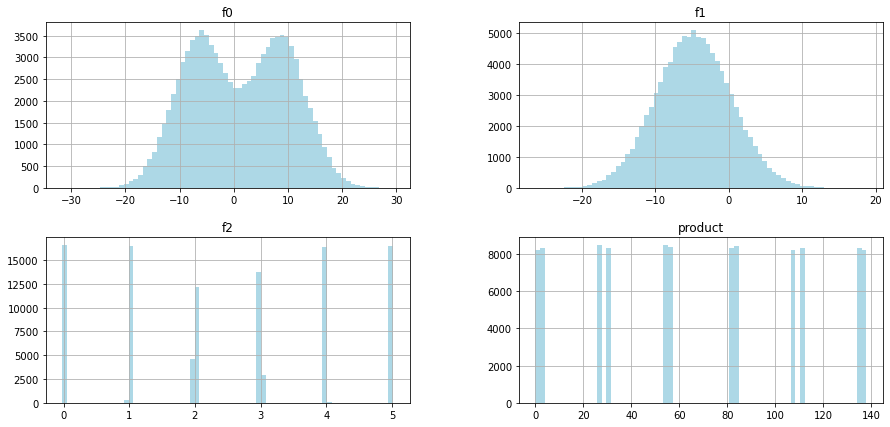

In [14]:
region_2.hist(figsize=(15, 7), bins=70, color='lightblue')
print('Распределение признаков во втором регионе')

Распределение признаков в третьем регионе


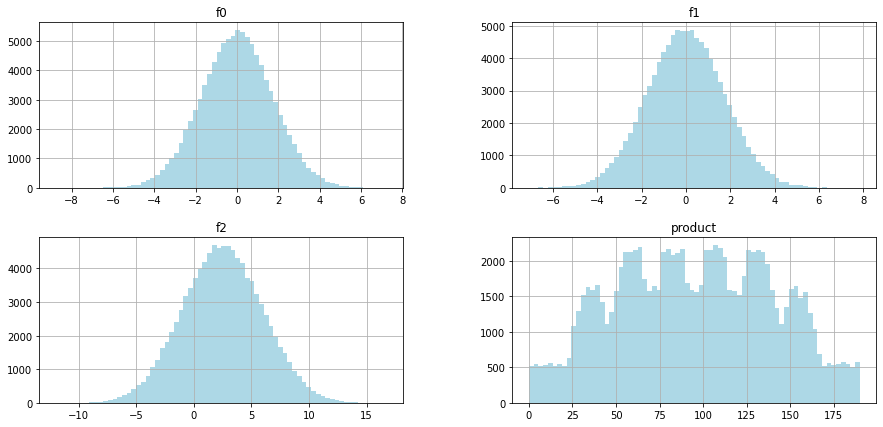

In [15]:
region_3.hist(figsize=(15, 7), bins=70, color='lightblue')
print('Распределение признаков в третьем регионе')

Пропуски и дубликаты в данных отсутстуют, замена типа данных не потребовалась. В синтетических данных присутствуют выбросы, они важны, корректировать не будем.

## Обучение и проверка модели

In [16]:
state = np.random.RandomState(12345) #зафиксируем random_state

Для каждого региона подготовим основные показатели

In [17]:
def lr_model(region):
    features = region.drop(['product'], axis=1) #признаки
    target = region['product'] #целевой признак
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=state) #отделим 25% данных для валидационной выборки
    
    model = LinearRegression() #инициализируем модель LinearRegression
    model.fit(features_train, target_train) #обучим модель на тренировочной выборке
    predicted = pd.Series(model.predict(features_valid), index=features_valid.index) #получим предсказания модели на валидационной выборке
    
    print('Средний запас предсказанного сырья:', predicted.mean().round(3),'(тыс. баррелей).')
    print('RMSE модели линейной регрессии:', round(mean_squared_error(target_valid, predicted)**0.5, 3))
    
    return target_valid, predicted

In [18]:
print('Первый регион')
target_valid_1, predicted_1 = lr_model(region_1)
print()
print('Второй регион')
target_valid_2, predicted_2 = lr_model(region_2)
print()
print('Третий регион')
target_valid_3, predicted_3 = lr_model(region_3)
print()
#показатели для каждого региона

Первый регион
Средний запас предсказанного сырья: 92.593 (тыс. баррелей).
RMSE модели линейной регрессии: 37.579

Второй регион
Средний запас предсказанного сырья: 68.77 (тыс. баррелей).
RMSE модели линейной регрессии: 0.89

Третий регион
Средний запас предсказанного сырья: 95.088 (тыс. баррелей).
RMSE модели линейной регрессии: 39.958



После обучения и проверки модели лучший показатель метрики оценки качества модели во 2 регионе.
Данные по 1 и 3 регионам показывают большой разброс, предсказания на валидационных выборках не отображают реальные запасы.

## Подготовка к расчёту прибыли

Сохраним  ключевые значения в отдельных переменных

In [19]:
AREAS = 500 #количество исследуемых точек
BEST_AREAS = 200 #количество лучших точек для разработки, отобранных с помощью машинного обучения
BUDGET = 10000000000 #бюджет на разработку скважин в регионе 
INCOME = 450000 #доход с каждой единицы продукта (рублей за 1 тыс. баррелей)
BOOTSTRAP = 1000 #количество выборок для bootstrap

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [20]:
break_even_amount = BUDGET / BEST_AREAS / INCOME
print('Достаточный объём сырья для безубыточной разработки новой скважины', round(break_even_amount,3), '(тыс. баррелей).')

Достаточный объём сырья для безубыточной разработки новой скважины 111.111 (тыс. баррелей).


In [21]:
print('Средний запас в каждом регионе')
print('№1:',round(region_1['product'].mean(),3), '(тыс. баррелей).')
print('№2:',round(region_2['product'].mean(),3), '(тыс. баррелей).')
print('№3:',round(region_3['product'].mean(),3), '(тыс. баррелей).')

Средний запас в каждом регионе
№1: 92.5 (тыс. баррелей).
№2: 68.825 (тыс. баррелей).
№3: 95.0 (тыс. баррелей).


Средний запас сырья во всех 3 регионах меньше достаточного объема для разработки новой скважины.

## Расчёт прибыли и рисков

In [22]:
def revenue(target, predicted, count):
    pred_sorted = predicted.sort_values(ascending=False)
    selected = target[pred_sorted.index][:count]
    return INCOME * selected.sum() - BUDGET

In [23]:
def profit_risk(target, predicted):
    target = target.reset_index(drop=True)
    predicted = predicted.reset_index(drop=True)
    benefit = []
    risk = []
    for i in range(BOOTSTRAP):
        target_subsample = target.sample(AREAS, replace = True, random_state = state)
        pred_subsample = predicted[target_subsample.index]
        profit= revenue(target_subsample, pred_subsample, BEST_AREAS)
        benefit.append(profit)

    
    benefit = pd.Series(benefit)
    risk = (benefit < 0).mean()
    
    benefit.hist(figsize=(12, 5), bins=50, color='lightblue')
    plt.grid(True)
    plt.axvline(benefit.quantile(0.025), color='blue')
    plt.axvline(benefit.quantile(0.975), color='green')
    plt.legend(['Доверительный 95% интервал от', 'Доверительный 95% интервал до', 'Распределение прибыли'])
    plt.xlabel('Прибыль, руб.')
    plt.ylabel('Количество из 200 скважин')
    plt.show()
    
    print('Средняя прибыль',round(benefit.mean()), 'млн.')
    print('Доверительный интервал от', round(benefit.quantile(0.025)), 'до', round(benefit.quantile(0.975)))
    print('Риск убытка',risk * 100,'%')
    
#функция для расчета методом boostrap по 1000 выборкам, отобрали лучшие 200 скважин из случайных 500

Первый регион


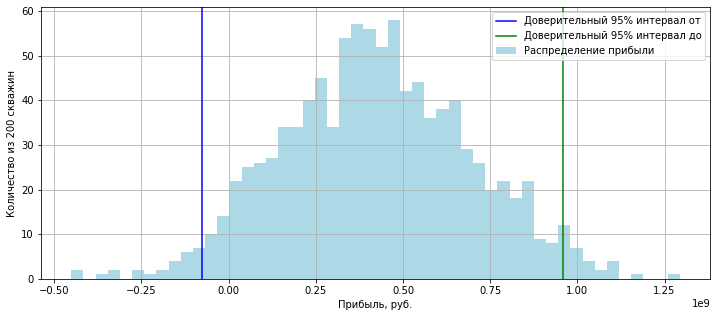

Средняя прибыль 423897238 млн.
Доверительный интервал от -76187814 до 957846532
Риск убытка 4.8 %


In [24]:
print('Первый регион')
profit_risk(target_valid_1, predicted_1)

Второй регион


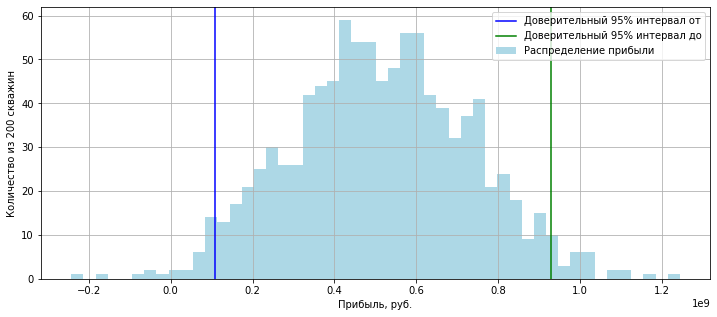

Средняя прибыль 513256699 млн.
Доверительный интервал от 108066895 до 928574439
Риск убытка 0.6 %


In [25]:
print('Второй регион')
profit_risk(target_valid_2, predicted_2)

Третий регион


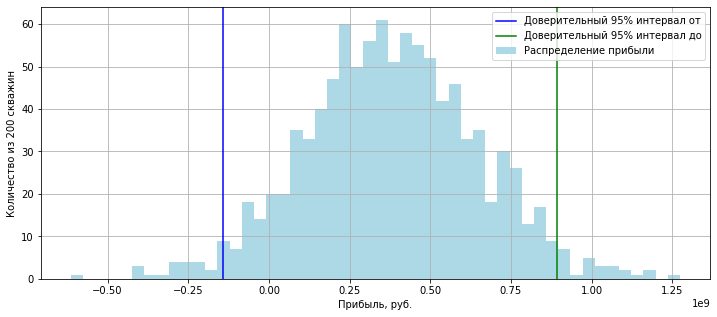

Средняя прибыль 381120360 млн.
Доверительный интервал от -142800630 до 893380566
Риск убытка 7.3999999999999995 %


In [26]:
print('Третий регион')
profit_risk(target_valid_3, predicted_3)

Для метода boostrap по 1000 выборкам, отобрали лучшие 200 скважин из случайных 500.
По всем показателям для бурения новой скважины выбираем 2 регион с наибольшей средней прибылью и наименьшим процентом риска убытка.

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Вывод</b>
    
При подготовке данных пропуски и дубликаты в данных отсутствовали, замена типа данных не потребовалась. В синтетических данных присутствуют выбросы, они важны, корректировать не будем.
    
После обучения и проверки модели лучший показатель метрики оценки качества модели во 2 регионе.Данные по 1 и 3 регионам показывают большой разброс, предсказания на валидационных выборках не отображают реальные запасы.
    
Первый регион<br>
Средний запас предсказанного сырья: 92.593 (тыс. баррелей).<br>
RMSE модели линейной регрессии: 37.579<br>

Второй регион<br>
Средний запас предсказанного сырья: 68.77 (тыс. баррелей).<br>
RMSE модели линейной регрессии: 0.89<br>
    
Третий регион<br>
Средний запас предсказанного сырья: 95.088 (тыс. баррелей).<br>
RMSE модели линейной регрессии: 39.958<br>
    
    
Достаточный объём сырья для безубыточной разработки новой скважины 111.111 (тыс. баррелей) <br>
Реальный средний запас в каждом регионе<br>
№1: 92.5 (тыс. баррелей).<br>
№2: 68.825 (тыс. баррелей).<br>
№3: 95.0 (тыс. баррелей).<br>
Средний запас сырья во всех 3 регионах меньше достаточного объема для разработки новой скважины.
    
    
    
Для метода boostrap по 1000 выборкам, отобрали лучшие 200 скважин из случайных 500. 
    
- Первый регион <br>
Средняя прибыль 423897238 млн.<br>
Доверительный интевал от -76187814 до 957846532<br>
Риск убытка 4.8 %<br>
    
    
- Второй регион<br>
Средняя прибыль 513256699 млн.<br>
Доверительный интевал от 108066895 до 928574439<br>
Риск убытка 0.6 %<br>
    
    
- Третий регион<br>
Средняя прибыль 381120360 млн.<br>
Доверительный интевал от -142800630 до 893380566<br>
Риск убытка 7.4 %<br>

    
По всем показателям для бурения новой скважины выбираем 2 регион с наибольшей средней прибылью и наименьшим процентом риска убытка.